<a href="https://colab.research.google.com/github/njqm10/ProgrammingProjects/blob/main/DeepFaceGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Generating faces using Deep Convolutional Generative Adverserial Networks
<hr>
<p align="justify"><i>Important disclaimer (as requeried by some colleges): This project was mostly done by myself (with some cited exceptions). This project has nothing to do with my school activities or  institutionally-guided extracurriculars. I was the only contributor and programmer of the project. No teacher nor mentor was in-charge of supervising the project. I did this project for fun and to learn more about Deep Learning, Artificial Intelligence, and python programming. Online courses (on youtube and edx) were my main source of information. Thank you for your attention, and let us get right into it! </i></p>
<hr>
<p align="justify">Please, if you are going to run the code, do not run it all at the same time. Please do it cell by cell. Also, <b> ENABLE GOOGLE COLAB GPU </b>.</p>
<p align="justify">In this project, we are going to be creating (or at least trying to) brand-new human faces! We have all seen them, maybe through deepfake videos or in a facebook post. Machines are learning to do truly incredible things. But, how do they do this? During this project, we will be explaining the process behind these incredible feats and we will creat our very own model (keep in mind that due to limited data set, computing resources, and time we cannot expect to obtain indistinguishable human faces as a result, however, the results will be, in my opinion, as impressive.) </p>

### Approach
<p align="justify">For this experience, we will be using DCGANs (Deep Convolutional Generative Adverserial Neural Networks). This project could be replicated using VAEs (Variational Autoeconders) or other types of neural networks. However, I find DCGANs to be extremely fascinating and better than the other available options. We will be explaining DCGANs and other important concepts as we travel through the code. </p>

### Data Set
<p align="justify">We will be using a data set found in the website "kaggle". This data set pertains exclusively to them and I do not intend to pass this data set as my own. Specifically, we are going to be using the "CelebA" data set. This data set includes 203 thousand pictures of famouse people, along side certain anotations. We will not be using these anotations to recreate a total human-unsupervised environment.</p>


<p align="text">Import dependencies and libraries. These will be used all through the project. We will explain some of these later. Reading the comments in the code ("#") might be useful as well.</p>

In [ ]:
%%capture 
# capture is to not output anything
from google.colab import files #Download and upload files through google colab
from IPython import display #Manage what is outputed
import logging #Supress logs outputed from some of these libraries.
import warnings #Supress certain warnings such as "callig tf.function might be expensive"
import matplotlib.pyplot as plt #Library to plot and generate images
import tensorflow as tf #Tensorflow is used to create the neural networks
import numpy as np #Used to create matrixes and arrays
import PIL #Use to obtain RGB valus from pictures
import time #Use to track time
import os #Used to creat paths and manage files

!pip install mtcnn #Command to install mtcnn library
import mtcnn #Importing mtcnn (will explain what is mtcnn later)
from mtcnn.mtcnn import MTCNN

<p align="justify">The following code of chunck is used to import a file which will help us to boost the quality of images. Please note, that this is not the neural network itself, nor it is necessary for a good functionality. However, due to my computing and data set limitations, using this will be helpful to get more representantive results. This simple and recent MIT developped method/modification will help us to create better images and avoid overfitting with small-data sets.</p>

<p align="justify">This github repository was not created by me and I do not intend to pass it as my own. The copyright disclaimer is located at the end of this section of the portofolio.</p>

You can read the paper for this method at:
https://arxiv.org/pdf/2006.10738.pdf 

In [ ]:
!git clone https://github.com/mit-han-lab/data-efficient-gans #cloning github

Cloning into 'data-efficient-gans'...
remote: Enumerating objects: 596, done.
remote: Total 596 (delta 0), reused 0 (delta 0), pack-reused 596
Receiving objects: 100% (596/596), 23.08 MiB | 37.05 MiB/s, done.
Resolving deltas: 100% (334/334), done.


In [ ]:
#changing directory inside the github repository
%cd data-efficient-gans/
from DiffAugment_tf import * #importing everything from the github
#Returning to base directory
%cd -

/content/data-efficient-gans
/content


<p align="justify">To download something from kaggle, we have to use the kaggle API. If you want to replicate this project and execute the code by yourself, you will need to create a kaggle account. After having your kaggle account, you go to your profile and request a API token. This will download a kaggle.json file that you will use. However, you will have no problem reading the project without executing the code by yourself. </p>

In [ ]:
warnings.filterwarnings("ignore") #ignore warnings

<p align="justify">If you are executing the code along side, this is where you upload the API Token</p>

In [ ]:
uploaded=files.upload() #Upload the downloaded kaggle.json API token

Saving kaggle.json to kaggle.json


<p align="justify">Now we write some code to finally download the data</p>

In [ ]:
!mkdir -p ~/.kaggle #Making an appropriate directory for the token (required by kaggle)
!cp kaggle.json ~/.kaggle/ #Making a copy of the token and putting it in the correct place
!ls ~/.kaggle #Making sure the token is inside 
!chmod 600 /root/.kaggle/kaggle.json #Permission and access

!kaggle datasets download -d jessicali9530/celeba-dataset #Actual download

kaggle.json
 99% 1.32G/1.33G [00:12<00:00, 126MB/s]
100% 1.33G/1.33G [00:12<00:00, 117MB/s]


<p align="justify">Unzip the downloaded data</p>

In [ ]:
%%capture
!unzip celeba-dataset.zip #will take a while

####Data set manipulation
<p align="justify">Now, we have loaded 203 thousand images into our directory. However, it is important to understand that this is not enough. Computers cannot actually "read" images. So, if we do not manipulate this data in a useful manner, these images are still useless.</p>

<p align="justify">To transform the data into an appropriate form, we first have to understand what computers can understand and work with. Computers can work with numbers and characters (which are interpreted with a numerical code, so numbers basically). So, we have to try to write images as numbers.</p>

<p align="justify">In the case of grayscale-images, this is an easy enough task. Every pixel in a gray image has a set value. This value ranges from 0 to 255, where 0 is black and 255 is white. So, each pixel will be described numerically between 0 and 255. To store this image with numerical values, we could use a 2D matrix. Think of a 2D matrix as a grid. If our image is 1080*1080, this basically means that our matrix will have 1080 columns and 1080 rows, and that each value on the matrix will represent the color of each pixel. Think of it as grid.</p>

<p align="justify">The following diagram may help for a better understanding.</p>

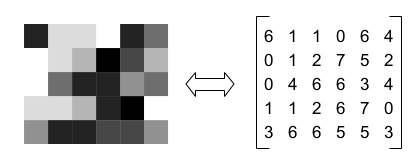

<p align="justify">For the sake of simplicity I will use the term matrix instead of tensor. </p>

<p align="justify">But how do we work with colored-images then? Well, it turns out that there is a numeric way to represent them as well. This is known as "RGB". Where R means Red, G means Green and B means Blue. Each individual value in the RGB code, goes from 0 to 255. So for example, these colors are described by: </p>

*   Red= (255,0,0) (Pure red)
*   Green=(0,255,0) (Pure green)
*   Blue=(0,0,255) (Pure blue)

And of course, we can combine these numbers to get any color
*   Pink=(255,192,203)
*   Yellow=(255,255,0)

<p align="justify">But how do we store these? Sure, we now know how to decribe 1 single pixel in an image, but we need to describe an entire image. To do this, we are going to be using a 3D matrix. Think of a 3D matrix as a cube made from smaller cubes. A rubic cube would be an example of a 3x3 3D matrix. In the front layer we will store de R values for the image. In the middle layer, we will store the G values, and in the last layer we will store the B values. </p>

The following image can help us better understand:

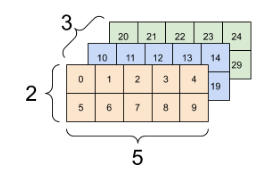

<p align="justify">Where the first layer will represent the Red values, the middle layer will represent the Green values (even though it is colored blue) and the last layer will represent Blue values (even though it is colored green). This matrix would describe a 3x5 colored image.</p>

<p align="justify">We can use the PIL library to open and read images, converting directly to 3D matrix with the format (height, width, channels) also known as channels last. We have now succesfully converted a single image into a computer-friendly format. The following GetImage function will help us with that.</p>





In [ ]:
path1="img_align_celeba" 
name_path=os.path.join(path1,path1) #Create the path to the folder containing every single image

def GetImage(path):
  """
  Receives a path to an image as input
  Opens the image located at that path
  Converts it to an RGB matrix with channels last
  Converts it to a numpy array to facilitate indexing
  Returns a 3D numpy array (matrix) with all the necessary information
  """
  full_image=PIL.Image.open(path) #opens the image at "path" location
  full_image=full_image.convert("RGB") #Converts to RGB matrix
  full_image_array=np.asarray(full_image) #Converts to numpy array
  return full_image_array

<p align="justify"> We can see that our data storage method is working by grabbing the numerical data of an arbitrary image and trying to recreate the image</p>

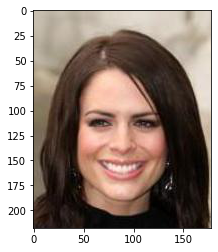

In [ ]:
#Creating a path for an arbitrary image
example_path=os.path.join(name_path,os.listdir(name_path)[1220])
example_image=GetImage(example_path)#Calling our function to get RGB matrix
plt.imshow(example_image[:,:,:]) #Plotting the image with the number matrix
#Note that we are not simply "opening the image", but recreating it to check if
#our numerical data method works

<p align="justify">Now, for optimization purposes, we still have a couple of steps more to have our single image ready for work. First, we are going to get rid of the backgrounds. Our Neural Network might get confused into thinking that the backgrounds constitute part of a face. Removing them is definetly the best choice. To do so, we will be using a open source facial detection model called MTCNN. MTCNN will detect the faces on our image and draw a box around it. We then are going to cut our image around this box to only have the face as our data. Lastly, we are going to be resizing our face into an 80*80 image. The number 80 was chosen because it is a high composite number (will help us later on). The following chunck of code has parts that I found on online forums (due to some bugs in the package).</p>

In [ ]:
def GetFace(model,full_image):
  """
  Asks for 2 inputs, a MTCNN model and a normal image we want to process
  Detects the face on the image and stores the box variables in which the face is.
  Convert into coordinates
  Cut the image
  Resize the image
  Returns an 3D RGB matrix as a numpy array that only contains the face or None
  if no face is detected
  """
  resize=(80,80) #Desired size
  face=model.detect_faces(full_image) #Detect faces

  if len(face)==0: #Return None for no faces detected
    return None
  x1, y1, width, height = face[0]['box'] #Save variables from the bux

  x1, y1 = abs(x1),abs(y1) #force detected pixel values to be positive (bug fix)

  x2, y2 = x1 + width, y1 + height # convert into coordinates
  face_pixels = full_image[y1:y2, x1:x2] #Cut image into face

  image = PIL.Image.fromarray(face_pixels)	
  image = image.resize(resize) # resize pixels to the model size
  face_array = np.asarray(image) #Convert into numpy array
  return face_array

We can look at how the GetFace function modifies our image with the following code

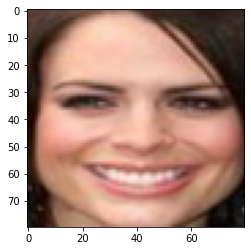

In [ ]:
example_model=MTCNN()
example_image=GetFace(example_model,example_image)
plt.imshow(example_image[:,:,:])

<p align="justify">Now, for our last step in data prep, we have to expand to multiple images. Our current method only works for a single image. Strictly speaking, we need to create a 4D matrix, however, this is a little bit hard to visualize. So, it is easier for us to think of it a list in which each element is a 3D RGB matrix. The first element will be the first image, the second element will be the second image and son on.</p>

<p align="justify">We can now create our usable data set for all images. Note that we will not use all 203 thousand images, because detecting a face in each of these will be quite a long task. Additionally, I do not have enough RAM (nor does google colab.) We will instead, use a subset of 30,000 images. The following code is supposed to be ran only 1 time. After it is initially ran (takes about 3 hours due to the complex nature of looping over and detecting the face for each photo) you do not need to re-run the following cell. The code will download a 500 MB file so you do nat have to re-run this cell. Uploading the file takes around 30 minutes and does not use RAM (So the process of re-running the whole project will be faster after the first time). Read the annotations in the code cell below.</p>

In [ ]:
###########################################################
###########################################################
####################IMPORTANT##############################

#ONLY RUN THIS CELL THE FIRST TIME YOU ARE RUNNING THE CODE
#AFTER RUNNING IT FOR THE FIRST TIME, YOU SHOULD USE THE 
#DOWNLOADED FILE INSTEAD OF THIS CELL

###########################################################
###########################################################

RawData=[] #Creating empty list to append the RGB matrixes
model=MTCNN() #Start the facial detection model
image_counter=0 #Count for the current image
for filename in os.listdir(name_path)[0:30000]:
  if image_counter%100==0:
    print(image_counter)
  image_path=os.path.join(name_path,filename)
  full_image=GetImage(image_path)
  face_image=GetFace(model,full_image)

  if face_image is None:
    continue
  RawData.append(face_image)
  image_counter+=1
RawData=np.array(RawData)
np.save("RawData.npy", RawData)
files.download("RawData.npy")

In [ ]:
######IMPORTANT########
#ONLY RUN THIS CELL IF YOU HAVE ALREADY DOWNLOADED THE RawData.npy file
#DO NOT RUN THIS CELL IN THE FIRST PROJECT RUN 
RawDataFile=files.upload() #Upload the Downloaded RawData.npy file
RawData=np.load("RawData.npy") #Load the data

<p align="justify">Now, we normalize the data from 0 to 255 (rgb values) to -1 to 1 (normalized rgb values) to facilitate computer calculations</p>

In [ ]:
train_images=(RawData-127.5)/127.5
train_images=np.float32(train_images)

<p align="justify">Now we shuffle the data and group it into batches. In our case, each batch has 128 pictures.</p>

In [ ]:
BUFFER_SIZE = 10000 #To shuffle
BATCH_SIZE = 128 #Batch size
BatchSize=128
# Batch and shuffle the data
np.random.shuffle(train_images) # Global Shuffle with numpy gives us better efficiency
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: (None, 80, 80, 3), types: tf.float32>

#### What are DCGANs and how do they work?
<p align="justify"> As it name suggests, DCGANs are a type of generative model. This simply means, that given certain information, they are capable of generating a result. Generative Models are not DCGAN exclusive (see for example, the DeepSong project in this portofolio.) However, they are the best method when it comes to <i>computer vision</i> (Image and Video processing).</p>

<p align="justify">To understand DCGANs, we first have to understand some other types of layers and methods we are going to be using. </p>

#### Convolutional Layers
<p align="justify"> Convolutional Layers are one of the most important type of layers when it comes to computer vision. Entire projects can be made with Neural Networks only dependent on convolutional layers (convolutional neural networks). A good example is the very own facial detection system we used to make our data set more representative and useful . Without going into much depth, convolutional layers are a way for computers to detect the underlying features behind images without them being supervised by a human. So, for example, a basic Convolutional Neural Network (CNN) will be capable of studying thousands and thousands of human pictures, and then be able to tell if a given picture is a human or not. When you think about it, this is extremely fascinating. There is a pretty big difference between every human, however, the CNN will be able to tell wether one is a human or not. </p>

<p align="justify"> How does it do this though? How can a CNN tell apart a human from a dog? How can it tell that an adult and a baby are both humans, even though they are extremely different? What about a man and a woman? How does it know that they are both part of a same collective? The key here is that CNNs do not analyze solely the direct information that they receive, but they also filter the data to get the key features in the data. So, even though a baby and an adult are visually different, they still have some similar key features the CNN can detect (eyes, nose, mouth, face-shape for example).</p>
<p align="justify">
Here is an example on how they pass filters to detect these features:
</p>

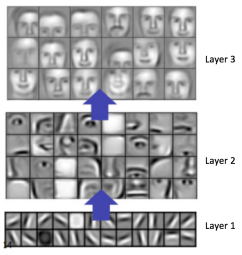

###Deconvolution layers
<p align="justify"> Alse known as Transposed Convolutional Layers. This layers are pretty much the opposite to convolutional layers. Given certain input, they scale it up to generate a brand new thing. For example, we might give it some random numbers, and the Deconvolution layer might generate a face out of it *wink* *wink*. Of course, to achieve the desired object, we first have to train the network.</p>

The following illustration might help

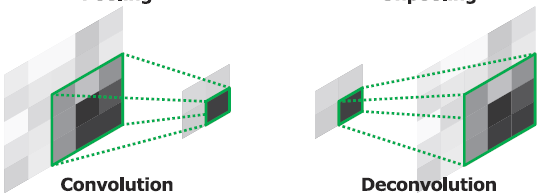


<p align="justify">Now that we understand the theoretical foundation for some of the layers we will be using, we can finally explain what exactly is a GAN. First of all, it is easier to understand a GAN as 2 Neural Networks instead of one. One of these Neural Networks will be called the "Generator" and the other one will be calle the "Discriminator". To understand the dynamics and relationship between the Discriminator and the Generator, we will use the following example:</p>

<p align="justify">Let us say that a kid has started attending art school. The kid, who knows absolutely nothing about art is tasked with drawing a beautiful landscape. For the sake of the example, lets say that the kid knows absolutely nothing about landscapes either. What will he draw? Well, he will most likely draw random things with random colors in it. The teacher in charge of the class will most definetly tell the student that his painting does not look like a landscape. Therefore, he tells the student that he is definetly doing something wrong. The student, extremely confused tries one more time. This time, he happened to draw a river by randomness and chance. The teachers looks at this new painting and tells him "You are doing better, however, this is still not a landscape". This process goes on and on, until years and years of pracitce later, the teacher is no longer able to tell the student-painted landscapes from the professional-painted ones. The kid now succesfully knows how to make landscapes.</p>

<p align="justify">In our Neural Network terms, the kid, will be the generator. At the beginning, the generator does not really know what he is doing. He generates random colors and calls it a face. However, the discriminator is right there to tell him that that is not a face. The discriminator, trains from real sample data. It learns from real images to classify real humans (with convolutional layers). The discriminator is our well-taught teacher. The generator however, learns from the feedback that it receives from the discriminator (and generates through deconvolution). The generator and the discriminator are in a way, competing with each other. The generators mission is to fool the discriminator. And the discriminators mission is to spot the fake faces generated by our generator. </p>

<p align="justify">As said before, the generator will generate "faces" from a random input or "noise". It does this through Transposed Convolution.</p>

In [ ]:
def MakeGenerator(latent_dim): #Think of latent_dim as the dimension of the input
  model=tf.keras.Sequential() #Define sequential model
  #Add Dense layer to connect inputs
  model.add(tf.keras.layers.Dense(5*5*128, use_bias=False, input_shape=(latent_dim,)))
  #Activation function (using LeakyReLU to avoid vanishing gradients)
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Reshape((5,5,128))) #Reshaping for correct output
  #Using our deconvolution layer, but keeping the size the same (1,1) stride
  model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=(1,1), padding="same",data_format="channels_last"))
  model.add(tf.keras.layers.LeakyReLU())
  #Using our deconvolution layer, but doubling the size  (2,2) stride
  model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size=3,strides=(2,2), padding="same",data_format="channels_last"))
  model.add(tf.keras.layers.LeakyReLU())
  #Using our deconvolution layer, but doubling the size  (2,2) stride
  model.add(tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=(2,2), padding="same",data_format="channels_last"))
  model.add(tf.keras.layers.LeakyReLU())
  #Using our deconvolution layer, but making the size 4 times bigger (4,4) stride
  model.add(tf.keras.layers.Conv2DTranspose(3, kernel_size=5, strides=(4,4),padding="same", data_format="channels_last", activation="tanh"))
  return model

In [ ]:
generator=MakeGenerator(128) #We initialize a generator with 

<p align="justify">As said before, the discriminator is a simple convolutional classifier (human or not human).</p>

In [ ]:
def MakeDiscriminator():
    model = tf.keras.Sequential()#Sequential model
    #Passing a convolutional layer with filter size 5,5 and reducing shape
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', data_format="channels_last", input_shape=[80, 80,3]))
    model.add(tf.keras.layers.LeakyReLU())
    #Passing a convolutional layer with filter size 5,5 and reducing shape
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',data_format="channels_last"))
    model.add(tf.keras.layers.LeakyReLU())
    #Passing a convolutional layer with filter size 5,5 and reducing shape
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',data_format="channels_last"))
    model.add(tf.keras.layers.LeakyReLU())
    #Passing a convolutional layer with filter size 5,5 and reducing shape
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',data_format="channels_last"))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Flatten())
    #Dropping neurons to not overfit
    model.add(tf.keras.layers.Dropout(0.3))
    #Defining the output as a decision
    model.add(tf.keras.layers.Dense(1))
    return model

In [ ]:
discriminator=MakeDiscriminator() #Initialize discriminator

<p align="justify">Define the loss function we are using. We could change this loss function for others. Theoretically, there are better options using min-max and Nash Equilibrium loss functions, however BinaryCrossentropy is more than enough.</p>

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

<p align="justify">Policy is part of the performance booster developped by MIT. To keep it simple, it a way to better train GANs which does not give place to overfitting and helps with the shape itself. The only chunck of code we are using from them is the "DiffAugment". Basically, we are using the criteria in "policy" as criteria for our Network.</p>

In [ ]:
policy = 'color,translation,cutout'

<p align="justify">The GenerateNoise function will generate a random noise to pass as input. These are completely random normally distributed numbers. This is necessary for the neural network to create new faces each time. If the input was not random, the generated face would be the same one each time.</p>

In [ ]:
def GenerateNoise(latent_dim):
  """
  Takes a dimension as input. This dimension has to correspond to the dimension
  with which we created our generator neural network.
  Returns a random matrix with appropriate shape to use in the generator.
  """
  noise=np.random.randn(BATCH_SIZE*latent_dim) #Generate a randomly distributed
  noise=noise.reshape(BATCH_SIZE,latent_dim) #Reshape the noise to appropiate dim
  return noise

<p align="justify"> The generate_and_save_images function is in charge of generated and saving 4 by 4 grids of images. This will help us to see the progression of the faces in different epochs. The following code was inspired by an example in tensorflow documentation on a GAN on MNIST data set to generate numbers. We also create the dislay_image function for later calls.</p>

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
  
def generate_and_save_images(model, epoch, test_input):
  """
  Takes model, epoch, and test_input as input.
  Model will be generator, epoch will be the current epoch
  And test_input will be a noise object. This noise object will
  Be kept constant (a seed) to generate the exact same face across
  The multiple epochs. This is to see how much better our NN gets.
  It saves this image in the current directoy and shows it.
  """
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4)) #Plot in a 4,4 size
  predictions=(predictions+1)/2 #Pass data from [-1,1] to [0,1] rgb
  for i in range(predictions.shape[0]): #shape[0] will be 16 as we have defined 
      logger = logging.getLogger() #Initialize a console logger
      old_level = logger.level #Save empty logget
      logger.setLevel(100)
      plt.subplot(4, 4, i+1) #Plot 
      plt.imshow(predictions[i, :, :, :]) #Show image in subplot
      plt.axis('off') #Dont show axis
      logger.setLevel(old_level) #Supress logg messages (matplob warnings)
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch)) #Save epoch image
  plt.show() #Show 4 by 4 grid

In [ ]:
def discriminator_loss(real_output, fake_output):
    """
    Define the discriminator_loss for training.
    Takes "real_output" and "fake_output" as input.
    "Real_output" is the own decision of the discriminator on wether or not 
    The image is real from real images.
    "Fake_output" is the the decision of the discriminator on wether or not
    The image is fake from fake images.
    """
    #Calculate loss from real_output, define ones for real images
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) 
    #Calculate loss from fake_output, define zeroes for fake images
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    #Calculate total loss by adding
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    #Calculate the loss as if generated images are real images
    return cross_entropy(tf.ones_like(fake_output), fake_output)

<p align="justify"> Define optimizers for both NN</p>

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

<p align="justify"> Save checkpoints of the model as we go </p>

In [ ]:
checkpoint_dir = './training_checkpoints' #Define a directory
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt") 
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

<p align="justify"> Define some Hyperparameters such as the number of epochs we will run on, and a seed to use to see actual progression and not generate completely diffferent people each time. In contrast to many other Neural Networks, more EPOCHS does not necessarily mean better results. There needs to be a min-max equilibrium. I defined 100 epochs because after around epoch 70, I feel like results get a little bit worse and the model could collapse. However, it would be hard to tell if I reached a local or global convergence. Feel free to modify the number of epochs as you wish.</p>

In [ ]:
EPOCHS = 100
latent_dim = 128
NumImages = 16
seed=seed = tf.random.normal([NumImages, latent_dim])

Define our training step with GradientTape to make it more customizable. This is te only part where we use the DiffAugment funciton not written by us.

In [ ]:
@tf.function #Increases performance
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, latent_dim]) #Generate a random noise
  #Use GradientTape to calculate gradients for loss
  with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
    generated_images=generator(noise, training=True) #Generate a fake image

    #Calculate real_output and fake_outputs; use DiffAugment
    real_output=discriminator(DiffAugment(images, policy=policy , channels_first=False ), training=True)
    fake_output=discriminator(DiffAugment(generated_images, policy=policy, channels_first=False), training=True)
    #Calculate loss
    gen_loss=generator_loss(fake_output)
    disc_loss=discriminator_loss(real_output, fake_output)
  #Define gradients
  gradients_of_generator = generator_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = discriminator_tape.gradient(disc_loss, discriminator.trainable_variables)
  #Apply gradients
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

<p align="justify">Define the training loop. Run train_step for every batch in every epoch. Save the model every 15 epochs.</p>

In [ ]:
def train(dataset,epochs,latent_dim,n_epochs=100):
  for epoch in range(epochs):
    start = time.time()
    for batch in dataset:
      train_step(batch)

    #Generate images as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  #Generate after final epoch 
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

Begin training

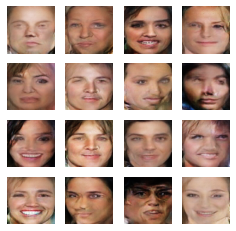

In [ ]:
train(train_dataset, EPOCHS,latent_dim)

<p align="justify">We can see that our faces are not perfect. However, they are identifiable as human faces. To better our results we would need a bigger and more representative data set. I believe, however, that the result is still impressive. We can also take a look at how the Neural Network got better and better by retrieving the images we saved. You can modify the cells to look at whichever epoch you like.</p>

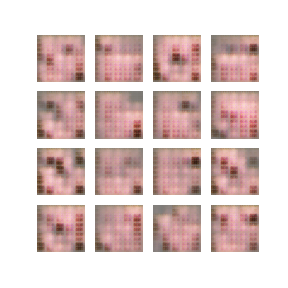

In [ ]:
RetrieveImages=[1,2,3,4,5,10,20,40,60,80,100]
display_image(RetrieveImages[0])

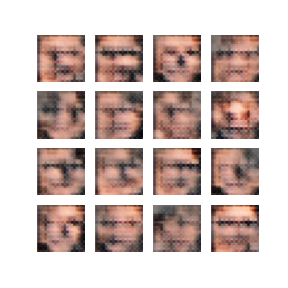

In [ ]:
RetrieveImages=[1,2,3,4,5,10,20,40,60,80,100]
display_image(RetrieveImages[1])

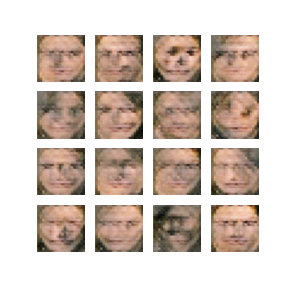

In [ ]:
RetrieveImages=[1,2,3,4,5,10,20,40,60,80,100]
display_image(RetrieveImages[2])

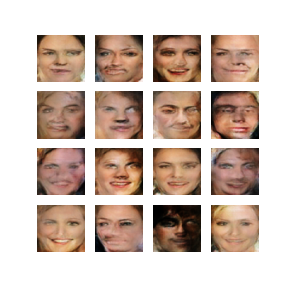

In [ ]:
RetrieveImages=[1,2,3,4,5,10,20,40,60,80,100]
display_image(RetrieveImages[6])

<p align="justify">We can also generate random faces (remember we used a seed during the training process) with completely random noise. Feel free to run the following cell until you get a good result.</p>

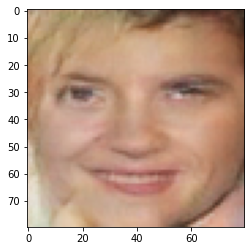

In [ ]:
noise =GenerateNoise(latent_dim)
Image=generator(noise)
Image=(Image+1)/2
plt.imshow(Image[0,:,:,:])

<p align="justify"> The following is an example of some good faces I got(remember that the process can be really random):</p>

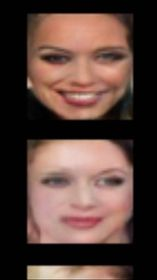


As requested, the copyright statement from DiffAugment from MIT is placed here:
  
```
@inproceedings{zhao2020diffaugment,
  title={Differentiable Augmentation for Data-Efficient GAN Training},
  author={Zhao, Shengyu and Liu, Zhijian and Lin, Ji and Zhu, Jun-Yan and Han, Song},
  booktitle={Conference on Neural Information Processing Systems (NeurIPS)},
  year={2020}
}
```

